# LSTM for forecasting Bitcoin price

This is the baseline model for comparison, which lacks ability to handle sequential nature of data. This will allow us to compare whether using a sequential model (i.e. LSTM) improves Bitcoin predictions.

In [1]:
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy
import tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Input, Masking, LeakyReLU
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Users/diana.xie/.pyenv/versions/3.6.8/envs/penn_challenge/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# 1. Preprocessing for LSTM

In [2]:
data = pd.read_csv(
    'bitcoin.csv', 
    index_col=0
)
data = data.sort_values('time_period_end')
data.drop(['time_period_start', 'time_period_end', 'time_open', 'time_close'], axis=1, inplace=True)

data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,7165.72,7165.72,7165.71,7165.71,0.021841,2
1,7168.30,7168.30,7168.30,7168.30,1.000000,2
2,7170.50,7170.50,7170.50,7170.50,0.002000,1
3,7169.20,7169.20,7169.20,7169.20,0.004000,2
4,7169.20,7169.20,7169.20,7169.20,0.002000,1


In [3]:
for feat in data.columns:
    scaler = MinMaxScaler()
    data[feat] = scaler.fit_transform(np.array(data[feat]).reshape(-1,1))
    if feat == 'price_open':
        target_scaler = deepcopy(scaler)  # save scaler for target, to transform back to original later

In [8]:
def window_stack(a: pd.DataFrame, width: int = 60):
    stack = [a.iloc[i:width+i] for i in range(0, len(a)-width+1)]
    return stack

# can turn back on for experimenting later, but right now for simplicity just scale entire col, not within time window 
# def window_scale(window_df: pd.DataFrame, scaler_to_use):
#     for feat in window_df.columns:
#         feat_scaler = deepcopy(scaler)
#         window_df[feat] = feat_scaler.fit_transform(np.array(window_df[feat]).reshape(-1, 1))
#     return window_df

def window_target(a: pd.DataFrame, width: int = 60):
    targets = np.array([a.iloc[width+i]['price_open']  for i in range(0, len(a)-width)])
#     targets = scaler.fit_transform(targets.reshape(-1,1))
    return targets

In [9]:
%%time

# get 60-sec time windows
width = 60
stacks = window_stack(data, width)[:-1]  # since last window's 9999 idx doesn't have a following 10000 idx target
targets = window_target(data, width)  # save scaler

# test
assert len(stacks)==len(targets), "The stacks and targets aren't of equal length.".format(x)

CPU times: user 5.98 s, sys: 108 ms, total: 6.09 s
Wall time: 6.13 s


In [7]:
# # scale within each 60-sec time window
# pbar = tqdm.tqdm(total=len(stacks))
# stack_scaled = []
# for window_df in stacks:
#     pbar.update(1)
#     stack_scaled.append(window_scale(window_df, MinMaxScaler()))  # if have time, test different scalers
# pbar.close()

# # test
# assert len(stack_scaled)==len(stacks), "The scaled stacks aren't of same length as unscaled.".format(x)

In [13]:
# convert to 3D array
# stack_arr = [np.array(x) for x in stack_scaled]
stack_arr = [np.array(x) for x in stacks]
stack_arr = np.array(stack_arr)
# features = stack_scaled[-1].columns
features = stacks[-1].columns

print('data shape: ', stack_arr.shape)
print('features: ', features.values)

data shape:  (9940, 60, 6)
features:  ['price_open' 'price_high' 'price_low' 'price_close' 'volume_traded'
 'trades_count']


In [14]:
# test
n_data, window_width, n_features = stack_arr.shape
assert n_data==len(stacks), "The n_data stack_arr[0] is incorrect shape.".format(x)
assert window_width==width, "The window_width stack_arr[1] is incorrect shape.".format(x)
assert n_features==len(features), "The n_features stack_arr[2] is incorrect shape.".format(x)

Treat each row as a "sequence".

In [15]:
train_idx, test_idx = train_test_split(range(0, len(stack_arr)), test_size=1 / 3, random_state=99)

X_train = stack_arr[train_idx]
y_train = np.array([targets[i] for i in train_idx])
assert len(X_train)==len(y_train), "X_train and y_train aren't of same len.".format(x)

X_test = stack_arr[test_idx]
y_test= np.array([targets[i] for i in test_idx])
assert len(X_test)==len(y_test), "X_train and y_train aren't of same len.".format(x)

assert len(X_train)+len(X_test)==len(stack_arr), "Total length of train & test don't add up to original.".format(x)

# 2. Evaluate LSTM

In [16]:
%%time

verbose, epochs, batch_size = 0, 15, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(100 , kernel_initializer='he_uniform', activation='relu'))
# model.add(Dense(1, activation='relu'))
# model.add(Dense(units=1, activation='softmax'))
model.add(Dense(1))
model.add(LeakyReLU(alpha=0.1))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics='mean_absolute_error')

# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

# evaluate
model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

52/52 [==============================] - 2s 30ms/step - loss: 0.0485 - mean_absolute_error: 0.0485
CPU times: user 4min 11s, sys: 1min 45s, total: 5min 57s
Wall time: 1min 34s


[0.048547688871622086, 0.048547688871622086]

## 2A. Inspect results

In [17]:
predictions = model.predict(X_test) 
predictions_unscaled = target_scaler.inverse_transform(np.array(predictions))
actuals = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

mae = mean_absolute_error(predictions_unscaled, actuals)
print('MAE, original scale: ', mae)

MAE, original scale:  2.7371207259920043


The error is not as low (i.e. not as good) as RFregressor. Let's see the distribution of predictions vs. actuals to see why:

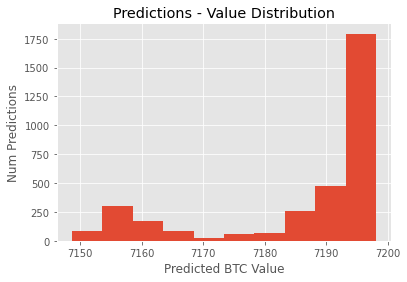

In [18]:
plt.hist(predictions_unscaled);
plt.title("Predictions - Value Distribution");
plt.xlabel("Predicted BTC Value");
plt.ylabel("Num Predictions");

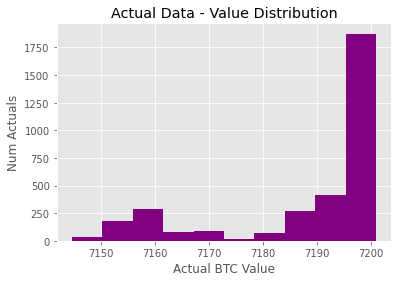

In [19]:
plt.hist(actuals, color='purple');
plt.title("Actual Data - Value Distribution");
plt.xlabel("Actual BTC Value");
plt.ylabel("Num Actuals");

It looks like the performance is lowered by LSTM inaccuracy in some parts of the bimodel distribution, such as the middle range (i.e. 7170-7200). 

# 3. Conclusion
The current LSTM (~ 2.73 MAE) performs better than the neural net example (~ 5.7 MAE), but not as well as RFregressor (~ 0.82 MAE), because it is unable to account for the bimodal nature of BTC value distribution. This is at least the case for a 60-sec window.

Therefore RFregressor performs the best out of the 3 tetsted models, with just a MAE of ~0.82 BTC error (average BTC value is ~7188)

# Future directions
- Further refinement of LSTM. Also explore other sequential learning architectures.
- Feature engineering, such as looking at correlation between BTC features
- Testing multiple time windows